# Ускоренные градиентные методы
Градиентный спуск является довольно обширным инструментом для минимизации функций и не имеет альтернатив для случая, когда количество параметров функции переваливает за миллион. Оказывается, однако, что базовый градиентный спуск может быть существенно ускорен простыми модификациями. Чтобы понять одну из основных проблем градиентного спуска стоит начать с изучения квадратичных функций и исторически первого ускоренного метода решения систем линейных уравнений на основе градиентного спуска.

## Метод Чебышёва для решения симметричных СЛАУ
Для квадратичной функции
$$
f(x)=\frac{1}{2}x^TAx-b^Tx+c
$$
с симметричной положительно определенной матрицей $A$ точкой минимума $x^*$ удовлетворяет соотношению
$$
\nabla f(x^*)=Ax^*-b=0.
$$
Если собственные числа матрицы удовлетворяют
$$
0<m= \lambda_1\leq\ldots\leq \lambda_n= M,
$$
то $f$ $m$-сильно выпукла и $M$-гладка, градиентный спуск может построить последовательность такую, что
$$
\|x_k-x^*\|=\mathcal{O}\left(\left(1-\frac{m}{M}\right)^k\|x_0-x^*\|\right).
$$
Сама же последовательность имеет вид
$$
x_{k+1}=x_k-\alpha_k(Ax_k-b)
$$
Вычитая $x^*$ из обоих частей получаем
$$
\begin{array}{rl}
x_{k+1}-x^*&=x_k-x^*-\alpha_k(Ax_k-b) \\
&=x_k-x^*-\alpha_k(Ax_k-Ax^*)\\
&=(I-\alpha_k A)(x_k-x^*).
\end{array}
$$
Используя рекуррентное соотношение дальше получаем
$$
x_k-x^*=P_k(A)(x_0-x^*), \tag{1}
$$
где $P_k$ - многочлен степени $k$ с корнями $\frac{1}{\alpha_k}$. Из этого соотношения к слову следует очень интересный факт: если в  градиентном спуске выбирать $\alpha_k=\frac{1}{\lambda_{k-1}}$, то мы сойдемся к точному решению за конечное число шагов. Этот факт обуславливается теоремой Гамильтона-Кэли: матрица $A$ обращает в $0$ свой характеристический многочлен $\chi_A$ с корнями, соответствующими собственным числам $A$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def show_eigendescent_and_permutations():
    A = np.random.rand(5, 5)
    A = A @ A.T
    b = np.random.rand(5)
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    eig, v = np.linalg.eigh(A)
    alphas = list(reversed([l ** -1 for l in eig]))
    x = np.zeros_like(b)
    
    errors = [np.linalg.norm(A @ x - b)]
    for alpha in alphas:
        x = x - alpha * (A @ x - b)
        errors.append(np.linalg.norm(A @ x - b))
    axs[0].plot([i for i in range(len(errors))], errors)
    axs[0].set_ylabel(r'|\Ax_k-b|', fontsize=20)
    axs[0].set_xlabel(r'k', fontsize=20)
    axs[0].set_yscale('log')
    
    x = np.zeros_like(b)
    alphas = np.abs(np.random.rand(20)) * (max(eig) ** -1)
    errors = [np.linalg.norm(A @ x - b)]
    for alpha in alphas:
        x = x - alpha * (A @ x - b)
        errors.append(np.linalg.norm(A @ x - b))
        
    x = np.zeros_like(b)
    random.shuffle(alphas)
    errors_shuffled = [np.linalg.norm(A @ x - b)]
    for alpha in alphas:
        x = x - alpha * (A @ x - b)
        errors_shuffled.append(np.linalg.norm(A @ x - b))
    
    axs[1].plot([i for i in range(len(errors))], errors, label='Unshuffled')
    axs[1].plot([i for i in range(len(errors_shuffled))], errors_shuffled, label='Shuffled')
    axs[1].set_ylabel('|\Ax_k-b|', fontsize=20)
    axs[1].set_xlabel('k', fontsize=20)
    axs[1].legend()
    print(f'Difference in errors on second last step: {errors[-2] - errors_shuffled[-2]}')
    print(f'Difference in errors on last step: {errors[-1] - errors_shuffled[-1]}')
    
    plt.close(fig)
    return fig

Difference in errors on second last step: 0.002382500103002838
Difference in errors on last step: -1.1102230246251565e-16


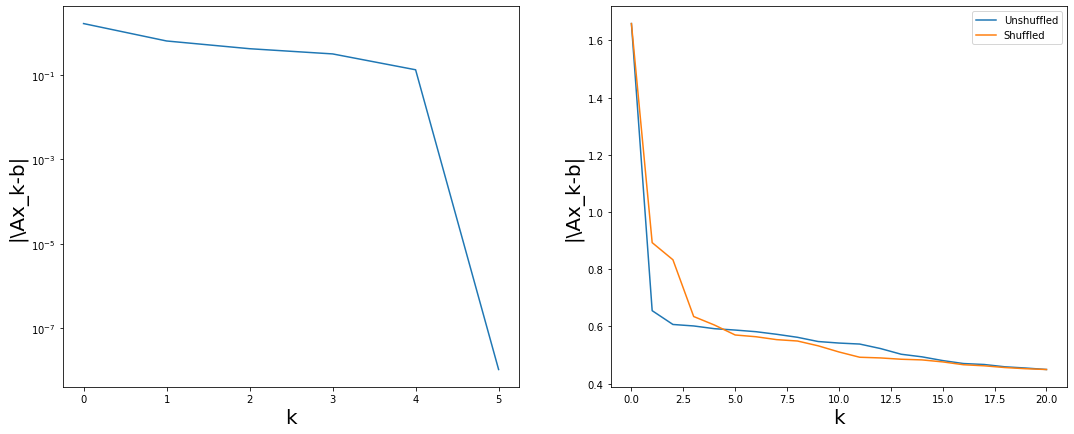

In [3]:
show_eigendescent_and_permutations()

К сожалению нахождение собственных чисел матрицы - более сложная задача, чем решение системы линейных уравнений, тем не менее алгоритмы на основе градиентного спуска, сходящиеся за конечное число шагов, существуют, но об этом чуть позже. Пока же нам инетерсно, можно ли подобрать размеры шагов зная только $m$ и $M$. Для начала отметим, что если $Ax=\lambda x$, то
$$
\begin{array}{rl}
P(A)x&=\left(\sum_{i=0}^kA^i\right)x\\
&=\sum_{i=0}^k\left(A^ix\right) \\
&=\sum_{i=0}^k\left(\lambda^ix\right)\\
&=P(\lambda)x.
\end{array}
$$
С другой стороны, так как для симметричной $A$ разным собственным числам соответствует ортогональные собственные вектора, пусть $x=\sum_{i=1}^n\beta_i\nu_i$, где $A\nu_i=\lambda_i\nu_i$, тогда
$$
\begin{array}{rl}
\|P(A)x\|^2&=\|P(A)\sum_{i=1}^n\beta_i\nu_i\|^2\\
&=\|\sum_{i=1}^nP(\lambda_i)\beta_i\nu_i\|^2 \\
&=\sum_{i=1}^n|P(\lambda_i)|^2\|\beta_i\nu_i\|^2\\
&\leq \max_{\lambda\in[m, M]}|P(\lambda)|^2\|x\|^2,\tag{2}
\end{array}
$$
при этом равенство достигается на собственном векторе, соответствующем максимальному собственному числу $A$.
Размер шага
$$
\alpha_k=\frac{2}{M+m}
$$
ведет к оптимальному приращению за одну итерацию и соответствует середине отрезка $[m, M]$. Тем не менее такой выбор не является оптимальным на несколько итераций, Чебышёв предложил здесь использовать многочлены, которые меньше всего отклоняются на всем отрезка $[m; M]$. 

<b>Теорема</b>. Пусть $T_n(x)$ - многочлен Чебышёва первого рода, т. е.
$$
\begin{cases}
T_0(x)&=1 \\
T_1(x)&=x \\
T_n(x)&=2xT_{n-1}(x)-T_{n-2}(x)
\end{cases}
$$
тогда среди многочленов с младшим коэффициентом $1$ степени $k$
$$
P_k(x)=\frac{T_k\left(\frac{M+m-2x}{M-m}\right)}{T_k\left(\frac{M+m}{M-m}\right)}\tag{3}
$$
имеет минимальное отклонение на отрезке $[m; M]$.
$$
\max_{x\in[m; M]}|P(x)|.
$$
<b>Доказательство.</b> Для начала отметим, что $T_k(x)\leq 1$ при $x\in[-1; 1]$ из чего следует
$$
P_k(x)\leq T_k\left(\frac{M+m}{M-m}\right)^{-1},~x\in[m;M].
$$
Не менее важным фактом является то, что экстремумы $T_k(x)$ находятся в точках
$$
x=\cos\left(\frac{\pi i}{k}\right),~i=0, \ldots, k
$$
и равняются $(-1)^i$ соовтетственно (в силу $T_k(x)=\cos(k\arccos x)$ при $x\in[-1; 1]$). Аналогично можно заключить, что и $|P_k|$ достигает экстремума в $k+1$ точке осцилируя между величинами
$$
P_k(\omega_i)=(-1)^iT_k\left(\frac{M+m}{M-m}\right)^{-1}
$$
при $\omega_i=m+(M-m)\cos\frac{\pi i}{k}$. Теперь допустим, что существует такой многочлен $Q$ степени $k$ и младшим коэффициентом $1$ такой, что
$$
\max_{x\in[m; M]}|Q(x)| < \max_{x\in[m; M]}|P_k(x)|
$$
в частности $Q(\omega_i)-P_k(\omega_i)$ больше нуля при $i+k\vdots 2$ и меньше нуля в остальных случаях. Таким образом на отрезке $[m;M]$ у многочлена $Q-P_k$ содержится $k$ корней. С другой стороны, так как у $Q$ и $P_k$ младшие коэффициенты равны $1$, то $Q(0)=P_k(0)=1$, из чего следует, что $0\notin [m;M]$ также является корнем $Q-P_k$, из чего следует, что $Q-P_k$ может быть только нулевым многочленом. $\#$

Используя корни многочлена $P_k$ в качестве величин, обратных размерам шага можно получить асимптотически оптимальное (по $k$ без учета $n$) в худшем случае приближение на $k$-ой итерации градиентного спуска. Корни $P_k$ вычисляются как
$$
\phi_i=m+(M-m)\cos\frac{\pi(2i+1)}{2k},~i=0, \ldots, k-1.
$$
Альтернативно можно поступить следующим образом: в силу $x_k=x^*+P_k(A)(x_0-x^*)$ и $P(0)=1$ получаем
$$
\begin{array}{rl}
x_k&=x^*+P_k(A)(x_0-x^*) \\
&=x^*+(I+\sum_{i=1}^k\beta_kA^i)(x_0-x^*)\\
&=x_0+\sum_{i=1}^k\beta_kA^ix_0-\sum_{i=0}^{k-1}\beta_{i+1}A^ib
\end{array}
$$
Описанные схемы обычно называют <i>полуитеративными методами Чебышёва</i> решения систем линейных уравнений. Полуитеративность обусловлена тем, что принцип работы основан на итеративной схеме градиентного спуска, но при этом в данном подходе мы заранее выбираем сколько итераций сделаем и выисляем только одно приближение. Для перехода от $k$ к $k+1$ в таком подходе потребуется полный пересчет, тем не менее рекурсивность второго порядка многочленов Чебышёва позволяет сделать этот переход более простым. Прежде, чем вывести этот переход, покажем, что скорость сходимости у метода Чебышёва лучше, чем у обычного градиентного спуска.

<b>Теорема (о скорости сходимости метода Чебышёва)</b>. Пусть $f$ - квадратичная функция, собственные числа которой зажаты в промежутке $[m; M]$ ($0<m<M$), тогда при использовании размеров шагов, заданными корнями многочлена $P_k$ из (3), для градиентного спуска выполняется следующая оценка
$$
\|x_k-x^*\|\leq \mathcal{O}\left(\left(1-\sqrt{\frac{m}{M}}\right)^k\|x_0-x^*\|\right)\tag{4}
$$
<b>Доказательство</b>. При $|x|\geq 1$
$$
T_k(x)=\frac{1}{2}\left(\left(x+\sqrt{x^2-1}\right)^k+\left(x-\sqrt{x^2-1}\right)^k\right)
$$
учитывая $T_k(x)\leq 1$ при $x\in[-1;1]$ получаем
$$
\begin{array}{rl}
|P_k(x)|&\leq T_k\left(\frac{M+m}{M-m}\right)^{-1} \\
&\leq 2 \left(\frac{M+m}{M-m}+\sqrt{\left(\frac{M+m}{M-m}\right)^2-1}\right)^{-k}\\
&=2 \left(\frac{M+m}{M-m}+\sqrt{\left(\frac{2\sqrt{Mm}}{M-m}\right)^2}\right)^{-k}\\
&=2 \left(\frac{(\sqrt{M}+\sqrt{m})^2}{\sqrt{M}^2-\sqrt{m}^2}\right)^{-k}\\
&=2 \left(\frac{\sqrt{M}+\sqrt{m}}{\sqrt{M}-\sqrt{m}}\right)^{-k}=2 \left(\frac{\sqrt{M}-\sqrt{m}}{\sqrt{M}+\sqrt{m}}\right)^k
\end{array}
$$
Последняя величина в этой цепочке является $\mathcal{O}\left(\left(1-\sqrt{\frac{m}{M}}\right)^k\right)$. Наконец учитывая (1) и (2) получаем утверждение теоремы. $\#$

Очевидным образом в силу $m<M$
$$
\left(1-\frac{\sqrt{m}}{\sqrt{M}}\right)<\left(1-\frac{m}{M}\right)
$$
Предположим, что мы хотим достичь точности $\epsilon$, таким образом мы получаем
$$
\left(1-\sqrt{\frac{m}{M}}\right)^k\|x_0-x^*\|\leq \epsilon
$$
$$
k\geq -\log\left(1-\sqrt{\frac{m}{M}}\right)^{-1} \log\frac{\|x_0-x^*\|}{\epsilon}\geq \sqrt{\frac{M}{m}}\log\frac{\|x_0-x^*\|}{\epsilon}
$$
Последнее неравенство опирается на $\log(1+x)\leq x$, при этом стоит иметь в виду, что $\lim_{x\rightarrow 0}\frac{\log(1+x)}{x}=1$. В обычном градиентном спуске мультипликативный фактор $\sqrt{\frac{M}{m}}$ становится $\frac{M}{m}$

In [4]:
import scipy as sp
import scipy.linalg

def show_chebyshev_semiiterations():
    A = np.random.rand(5, 5)
    A = A @ A.T
    sD = sp.linalg.sqrtm(np.linalg.inv(np.diag(np.diag(A))))
    A = sD.T @ A @ sD
    b = np.random.rand(5)
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    eig, v = np.linalg.eigh(A)
    m, M = eig[0], eig[-1]
    print('Condition(A):', M / m)
    print(m, M)
    x = np.zeros_like(b)
    y = x
    
    iters = 5000
    
    alphas = list(reversed([(0.5 * (m + M - (M - m) * np.cos(np.pi * (2 * i + 1) / 2 / iters))) ** -1 for i in range(iters)]))
    
    errors_chebyshev = [np.linalg.norm(A @ x - b)]
    errors_best_local = [np.linalg.norm(A @ x - b)]
    
    for alpha in alphas[:len(alphas) - len(alphas) // 2]:
        x = x - alpha * (A @ x - b)
        errors_chebyshev.append(np.linalg.norm(A @ x - b))
        
    x = y
    for alpha in alphas:
        x = x - (2 / (m + M)) * (A @ x - b)
        errors_best_local.append(np.linalg.norm(A @ x - b))
        
        
    axs.plot([i for i in range(len(errors_chebyshev))], errors_chebyshev, label='Chebyshev')
    axs.plot([i for i in range(len(errors_best_local))], errors_best_local, label='Basic')
    axs.legend()
    axs.set_ylabel(r'|\Ax_k-b|', fontsize=20)
    axs.set_xlabel(r'k', fontsize=20)
    axs.set_yscale('log')

Condition(A): 430.21209016204017
0.00966928656873543 4.159843985111411


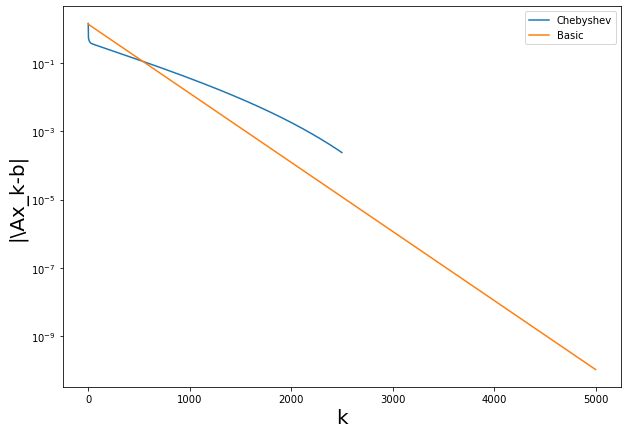

In [5]:
show_chebyshev_semiiterations()

## Итеративная реализация метода Чебышёва
Обозначим $\phi=\frac{M+m}{M-m}$, $\theta_k=T_k(\phi)$, $\gamma_k=\frac{\theta_k}{\theta_{k+1}}$, тогда
$$
\begin{array}{rl}
P_{k+1}(x)&=\frac{T_{k+1}\left(\phi-\frac{2x}{M+m}\right)}{\theta_{k+1}} \\
&=\frac{2\left(\phi-\frac{2x}{M+m}\right)T_{k}\left(\phi-\frac{2x}{M+m}\right)-T_{k-1}\left(\phi-\frac{2x}{M+m}\right)}{\theta_{k+1}}\\
&=\frac{2\gamma_k\left(\phi-\frac{2x}{M+m}\right)T_{k}\left(\phi-\frac{2x}{M+m}\right)}{\theta_k}-\frac{\gamma_k\gamma_{k-1}T_{k-1}\left(\phi-\frac{2x}{M+m}\right)}{\theta_{k-1}}\\
   &=2\gamma_k\left(\phi-\frac{2x}{M-m}\right)P_k(x)-\gamma_k\gamma_{k-1}P_{k-1}(x)
\end{array}
$$
Учитывая $\theta_{k+1}=2\phi\theta_k-\theta_{k-1}$ получаем
$$
P_{k+1}(x)=\left(1-\frac{4\gamma_kx}{M-m}\right)P_k(x)+\gamma_k\gamma_{k-1}(P_k(x)-P_{k-1}(x))
$$
При $x_k-x^*=P_k(A)(x_0-x^*)$, то 
$$
\begin{array}{rl}
x_{k+1}-x^*&=x_k-x^*-\frac{4\gamma_k}{M-m}A(x_k-x^*)+\gamma_k\gamma_{k-1}(x_k-x_{k-1}) \\
x_{k+1}&=x_k-\frac{4\gamma_k}{M-m}(\underbrace{Ax_k-b}_{\nabla f(x_k)})+\gamma_k\gamma_{k-1}(\underbrace{x_k-x_{k-1}}_{\mbox{момент}})
\end{array}
$$
последнее равенство позволяет без особых трудностей вычислять $x_k$ в соответствием с методом Чебышёва запоминая дополнительно $x_{k-1}$.

## Метод тяжелого шарика
Как оказывается, схожей асимптотической скорости достигает упрощенный метод
$$
x_{k+1}=x_k-\alpha(Ax_k-b)+\beta(x_k-x_{k-1}).
$$
Эту последовательность можно свести к первому порядку следующим образом
$$
\begin{pmatrix}
x_{k+1}-x^* \\
x_k-x^*
\end{pmatrix}
=
\begin{pmatrix}
(1+\beta)I-\alpha A & -\beta I \\
I & 0
\end{pmatrix}
\begin{pmatrix}
x_k-x^* \\
x_{k-1}-x^*
\end{pmatrix}.
$$
Матрица перехода здесь несимметричная и оказывается, что выгодно подобрать $\alpha, \beta$ так, чтобы её корни были мнимыми. Блоки матрицы симметричны, поэтому после диагонализации $A$ и перестановки строк и столбцов матрица перехода приходит к блочному-диагональному виду, состоящему из блоков 2x2 следующего вида
$$
\begin{pmatrix}
1+\beta-\alpha \lambda_i & -\beta \\
1 & 0
\end{pmatrix},
$$
где $\lambda_i$ как и прежде собственные числа $A$. Собственные числа блока получаются из решения квадратного уравнения
$$
z_{12}=\frac{(1+\beta-\alpha\lambda_i)\pm\sqrt{(1+\beta-\alpha\lambda_i)^2-4\beta}}{2}
$$

Подкоренное выражение является квадратным относительно $\beta$ с корнями $(1\pm\sqrt{\alpha\lambda_i})^2$. Соответственно при $\beta\in[(1-\sqrt{\alpha\lambda_i})^2; 1]$ выполняется 
$$
\begin{array}{rl}
(1+\beta-\alpha\lambda_i)^2-4\beta&\leq 0\\
|z_{12}|&=\frac{1}{2}\sqrt{(1+\beta-\alpha\lambda_i)^2+4\beta-(1+\beta-\alpha\lambda_i)^2}=\sqrt{\beta}
\end{array}
$$
Если $m\leq \lambda_1\leq\ldots\leq\lambda_n\leq M$, то минимальная граница для выполнения неравенства $\beta\geq(1-\sqrt{\alpha\lambda_i})^2$ для всех $i$ достигается на величине
$$
\beta\max\{(1-\sqrt{\alpha m})^2, (1-\sqrt{\alpha M})^2\}.
$$
Минимизируя это выражение по $\alpha$ получаем
$$
\alpha^*=\frac{4}{(\sqrt{m}+\sqrt{M})^2}
$$
и, соответственно,
$$
\beta^*=\left(\frac{\sqrt{M}-\sqrt{m}}{\sqrt{M}+\sqrt{m}}\right)^2
$$
что ведет к той же асимптотической сложности, что и в случае метода Чебышёва.

In [6]:
import scipy as sp
import scipy.linalg

def chebyshev_descent(x_0: np.ndarray,
                      A: np.ndarray,
                      b: np.ndarray,
                      m: float,
                      M: float,
                      iters: int):
    """
    Применяет метод Чебышёва к квадратичной функции, заданной A, b
    с начальным приближением x_0. Все собственные числа A лежат на отрезке
    [m: M], m > 0.
    
    Args:
        x_0: ndarray размером (n)
        A: ndarray размером (n, n)
        b: ndarray размером (n)
        m, M: границы спектра A
        iters: количество итераций спуска
        
    Returns:
        последовательность [x_0, x_1, ..., x_iters]
    """
    phi = (m + M) / (M - m)
    cur_gamma   = 1.0 / phi
    prev_gamma  = 0
    result = [x_0]
    cur_x = x_0
    prev_x = x_0
    for i in range(iters):
        t = cur_x
        alpha = 4 * cur_gamma / (M - m)
        beta = cur_gamma * prev_gamma
        cur_x = cur_x - alpha * (A @ cur_x - b) + beta * (cur_x - prev_x)
        prev_x = t
        t = cur_gamma
        cur_gamma = 1.0 / (2 * phi - cur_gamma)
        prev_gamma = t
        result.append(cur_x.copy())
    return result

def heavy_ball_descent(x_0: np.ndarray,
                       A: np.ndarray,
                       b: np.ndarray,
                       m: float,
                       M: float,
                       iters: int):
    alpha = 4 / (m ** 0.5 + M ** 0.5) ** 2
    beta = ((M ** 0.5 - m ** 0.5) / (M ** 0.5 + m ** 0.5)) ** 2
    result = [x_0]
    cur_x = x_0
    prev_x = x_0
    for i in range(iters):
        t = cur_x
        cur_x = cur_x - alpha * (A @ cur_x - b) + beta * (cur_x - prev_x)
        prev_x = t
        result.append(cur_x.copy())
    return result

def show_chebyshev_and_gradient():
    A = np.random.rand(5, 5)
    A = A @ A.T
    sD = sp.linalg.sqrtm(np.linalg.inv(np.diag(np.diag(A))))
    A = sD.T @ A @ sD
    b = np.random.rand(5)
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    eig, v = np.linalg.eigh(A)
    m, M = eig[0], eig[-1]
    print('Condition(A):', M / m)
    x = np.zeros_like(b)
    
    iters = 500
    
    estimates_heavy_ball = heavy_ball_descent(x, A, b, m, M, iters)
    estimates_chebyshev = chebyshev_descent(x, A, b, m, M, iters)
    
    axs.plot([i for i in range(len(estimates_heavy_ball))], [np.linalg.norm(A @ x - b) for x in estimates_heavy_ball], label='Heavy ball')
    axs.plot([i for i in range(len(estimates_chebyshev))], [np.linalg.norm(A @ x - b) for x in estimates_chebyshev], label='Chebyshev')
    axs.legend()
    axs.set_ylabel(r'|Ax_k-b|', fontsize=20)
    axs.set_xlabel(r'k', fontsize=20)
    axs.set_yscale('log')
    plt.close(fig)
    return fig

Condition(A): 6126.852499456007


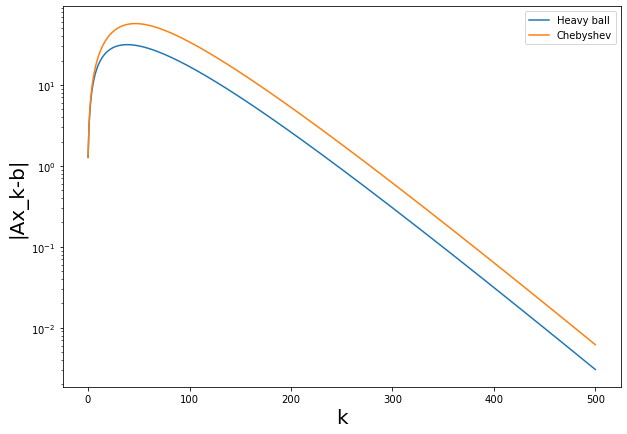

In [7]:
show_chebyshev_and_gradient()

## Метод Нестерова
Как оказывается, оценка (4) является точной для алгоритмов, использующих при построении нового приближения линейную комбинацию предыдущих приближений и их градиентов, по аналогии оценка $\mathcal{O}\left(\frac{1}{k^2}\right)$ является точной для выпуклых функций. Более формально, рассмотрим последовательности $x_k$ вида
$$
x_k\in x_0+\langle\nabla f(x_0),\ldots, \nabla f(x_{k-1})\rangle\tag{5}.
$$
<b>Теорема (о нижней оценке градиентных методов для выпуклых функций)</b>. $\forall k\leq \frac{1}{2}(n-1), x_0~\exists f:\mathbb{R}^n\rightarrow\mathbb{R}$ являющаяся $M$-гладкой, что любой метод, удовлетворяющий (5), примененный к $f$ имеет нижнюю оценку
$$
f(x_k)-f(x^*)\geq \frac{\beta M||x_0-x^*||^2}{(k+1)^2},
$$ 
где $\beta>0$ - некоторая константа, не зависящая от $k, n, M, f, x_0$.

<b>Теорема (о нижней оценке градиентных методов для сильно выпуклых функций)</b>. $\forall k, x_0~\exists f:\mathbb{R}^\infty\rightarrow\mathbb{R}$ являющаяся $m$-сильно выпуклой и $M$-гладкой, что любой метод, удовлетворяющий (5), примененный к $f$ имеет нижнюю оценку
$$
\|x_k-x^*\|^2\geq \left(\frac{\sqrt{M}-\sqrt{m}}{\sqrt{M}+\sqrt{m}}\right)^{2k}||x_0-x^*||^2.
$$
Обе теоремы без доказательства. Первый метод, который достигал обоих этих оценок, был предложен Ю. Е. Нестеровым в 1984г., и являлся модификацией метода моментов следующей формы:
$$
x_{k+1}=x_k-\alpha_k\nabla f(x_k+\beta_k(x_k-x_{k-1}))+\beta_k(x_k-x_{k-1}),
$$
который традиционно имеет следующую форму
$$
\begin{array}{rl}
x_{k+1}&=y_k-\frac{1}{M}\nabla f(y_k) \\
\alpha_{k+1}:0&=\alpha_{k+1}^2-(1-\alpha_{k+1})\alpha_k^2-\alpha_{k+1}\frac{m}{M}\\
\beta_k&=\frac{\alpha_k(1-\alpha_k)}{\alpha_k^2+\alpha_{k+1}}\\
y_{k+1}&=x_{k+1}+\beta_k(x_{k+1}-x_k).
\end{array}
$$

Этот алгоритм является универсальным как для выпуклых, так и для сильно выпуклых функций, но при этом в случае сильной выпуклости может быть упрощен до
$$
\begin{array}{rl}
x_{k+1}&=y_k-\frac{1}{M}\nabla f(y_k) \\
y_{k+1}&=x_{k+1}+\frac{\sqrt{M}-\sqrt{m}}{\sqrt{M}+\sqrt{m}}(x_{k+1}-x_k).
\end{array}
$$

In [8]:
def nesterov_strongly_convex_descent(
                     x_0: np.ndarray,
                     A: np.ndarray,
                     b: np.ndarray,
                     m: float,
                     M: float,
                     iters: int):
    alpha = 1 / M
    beta = ((M ** 0.5 - m ** 0.5) / (M ** 0.5 + m ** 0.5))
    result = [x_0]
    cur_x = x_0
    cur_y = x_0
    for i in range(iters):
        next_x = cur_y - alpha * (A @ cur_y - b)
        cur_y = next_x + beta * (next_x - cur_x)
        cur_x, prev_x = next_x, cur_x
        result.append(cur_x.copy())
    return result

In [9]:
def show_nesterov_and_gradient():
    A = np.random.rand(5, 5)
    A = A @ A.T
    sD = sp.linalg.sqrtm(np.linalg.inv(np.diag(np.diag(A))))
    A = sD.T @ A @ sD
    b = np.random.rand(5)
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    eig, v = np.linalg.eigh(A)
    m, M = eig[0], eig[-1]
    print('Condition(A):', M / m)
    x = np.zeros_like(b)
    
    iters = 500
    
    estimates_heavy_ball = heavy_ball_descent(x, A, b, m, M, iters)
    estimates_nesterov = nesterov_strongly_convex_descent(x, A, b, m, M, iters)
    
    axs.plot([i for i in range(len(estimates_heavy_ball))], [np.linalg.norm(A @ x - b) for x in estimates_heavy_ball], label='Heavy ball')
    axs.plot([i for i in range(len(estimates_nesterov))], [np.linalg.norm(A @ x - b) for x in estimates_nesterov], label='Nesterov')
    axs.legend()
    axs.set_ylabel(r'|Ax_k-b|', fontsize=20)
    axs.set_xlabel(r'k', fontsize=20)
    axs.set_yscale('log')
    plt.close(fig)
    return fig

Condition(A): 160.28881730266627


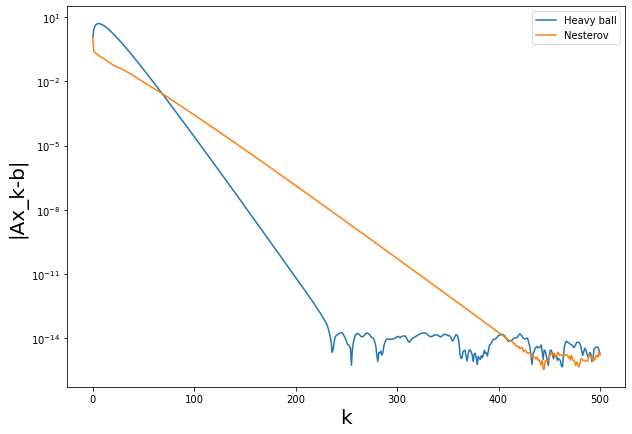

In [10]:
show_nesterov_and_gradient()